In [146]:
from astropy import units as u
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.nddata import CCDData
import ccdproc
from astropy.table import Table
from astropy.modeling import models
from matplotlib.colors import LogNorm
from photutils import aperture_photometry, CircularAperture, CircularAnnulus

from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)

from photutils.psf import IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [129]:
my_coords = [(219, 540.5), (85.6, 320.6), (75, 211.4), (428.3, 138), (542.5, 99.8), (713, 268.3), (746, 643.3), (820.7, 304), (378.6, 861.6), (966.5, 435.7)]


In [155]:
circular_r = 5.
annulus_r_in = 10.
annulus_r_out = 15.
aperture = CircularAperture(my_coords, r=circular_r) #[1-10]
annulus_aperture = CircularAnnulus(my_coords, r_in=annulus_r_in, r_out=annulus_r_out)
annulus_aperture

<CircularAnnulus([[219. , 540.5],
                  [ 85.6, 320.6],
                  [ 75. , 211.4],
                  [428.3, 138. ],
                  [542.5,  99.8],
                  [713. , 268.3],
                  [746. , 643.3],
                  [820.7, 304. ],
                  [378.6, 861.6],
                  [966.5, 435.7]], r_in=10.0, r_out=15.0)>

In [156]:
image_data = fits.getdata('/Users/kyleporter/Desktop/ASTR480/quadRU.fits')
phot_table = aperture_photometry(image_data, aperture, method='center')
phot_annulus_table = aperture_photometry(image_data, annulus_aperture, method='center')
phot_annulus_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,219.0,540.5,102028.79155688257
2,85.6,320.6,104897.09096993651
3,75.0,211.4,100991.65102480882
4,428.3,138.0,107478.8089789446
5,542.5,99.8,110918.6785893809
6,713.0,268.3,105222.51057817102
7,746.0,643.3,112384.35953570453
8,820.7,304.0,106487.18206141211


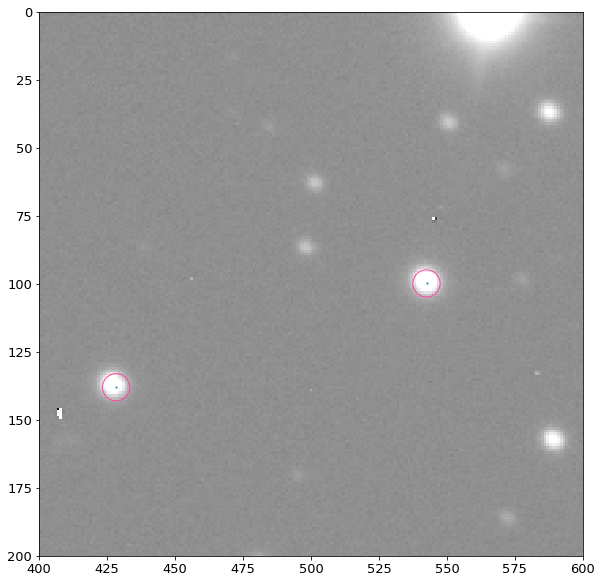

In [211]:
#image_file = fits.open('/Users/kyleporter/Desktop/ASTR480/quadRU.fits')
image_data = fits.getdata('/Users/kyleporter/Desktop/ASTR480/quadRU.fits')
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(phot_table['xcenter'], phot_table['ycenter'], s=1)  # "," is pixels.
ax.imshow(image_data, cmap='gray', norm=LogNorm(20,2000))
plt.xlim(400, 600)
plt.ylim(0, 200)
CircularAperture.plot(aperture, color="xkcd:Barbie Pink")
plt.gca().invert_yaxis()

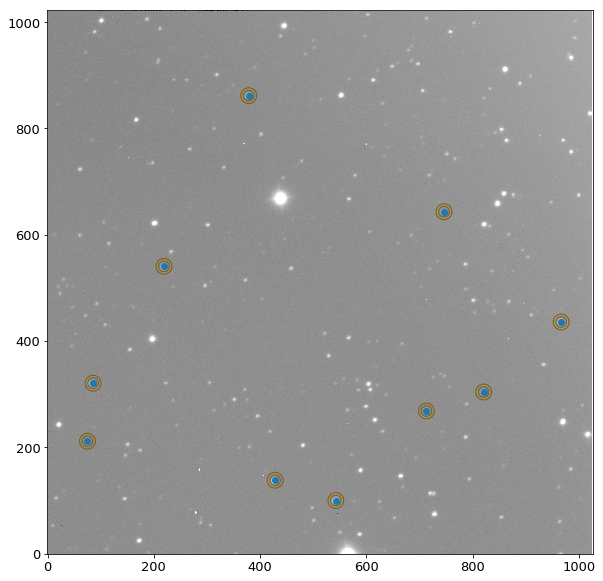

In [158]:
image_data = fits.getdata('/Users/kyleporter/Desktop/ASTR480/quadRU.fits')
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(phot_annulus_table['xcenter'], phot_annulus_table['ycenter'])  # "," is pixels.
ax.imshow(image_data, cmap='gray', norm=LogNorm(20,2000))
CircularAnnulus.plot(annulus_aperture, color="xkcd:poop")
plt.gca().invert_yaxis()

In [134]:
apers = [aperture, annulus_aperture]
total_table = aperture_photometry(image_data, apers)
bkg_mean = total_table['aperture_sum_1'] / annulus_aperture.area()
bkg_sum = bkg_mean * aperture.area()
final_sum = total_table['aperture_sum_0'] - bkg_sum
total_table['residual_aperture_sum'] = final_sum
total_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,residual_aperture_sum
,pix,pix,,,
int64,float64,float64,float64,float64,float64
1,219.0,540.5,72776.61301637124,73981.15664846815,63898.87421855506
2,85.6,320.6,99402.41691730602,84591.52447172604,89251.4339806989
3,75.0,211.4,12748.346533795455,62694.97911354566,5224.949040169975
4,428.3,138.0,102721.44638077776,91891.74998427213,91694.43638266511
5,542.5,99.8,158540.97916575527,100362.24457098528,146497.50981723703
6,713.0,268.3,29270.061341089,69231.34701292009,20962.29969953859
7,746.0,643.3,23560.66581809535,73582.55099888361,14730.759698229314
8,820.7,304.0,12588.91266175255,65639.04486891997,4712.227277482155


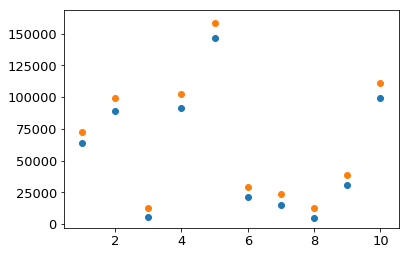

In [179]:
circular_r
annulus_r_in
annulus_r_out

fig, ax = plt.subplots()
ax.scatter(total_table["id"], total_table["residual_aperture_sum"])
ax.scatter(total_table["id"], total_table["aperture_sum_0"])
plt.show()

# PSF

In [139]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

bkgrms = MADStdBackgroundRMS()
std = bkgrms(image_data)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
from photutils.psf import IterativelySubtractedPSFPhotometry
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=1, fitshape=(11,11))
result_tab = photometry(image=image_data)
residual_image = photometry.get_residual_image()

In [168]:
photometry = BasicPSFPhotometry(group_maker=daogroup,
                                bkg_estimator=mmm_bkg,
                                psf_model=psf_model,
                                fitter=LevMarLSQFitter(),
                                fitshape=(11,11))
pos = Table(names=['x_0', 'y_0'], data=[total_table['xcenter'],
                                        total_table['ycenter']])
result_tab = photometry(image=image_data, init_guesses=pos)
residual_image = photometry.get_residual_image()
result_tab

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
pix,pix,,,,,,,,,
float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
219.0,540.5,90692.93821499156,1,1,218.9185531676534,540.1982899065613,100081.74779725476,949.1538284297076,0.027122861687984123,0.027169400153185856
85.6,320.6,135896.870467394,2,2,84.44901871896498,320.03336450431874,156177.69897390774,1553.622636695694,0.02874387834865584,0.028527991308197227
75.0,211.4,8234.372588588545,3,3,73.49838659278066,210.6778053746095,9812.506424812018,141.3907525827105,0.041596909763368974,0.04121967228898277
428.3,138.0,147657.44181308165,4,4,427.16897949281076,136.88910574031937,170252.76752828195,1568.0735553072236,0.026390465383100033,0.02644633213706596
542.5,99.8,222223.63628249944,5,5,542.2877243157765,98.78975008436574,247067.85053539794,2254.1571482131585,0.026127279641068247,0.026224657294401866
713.0,268.3,33706.338559105774,6,6,712.1569521304897,267.1364035685652,38104.8584422436,338.2459294817165,0.025435462196639606,0.025437857821189357
746.0,643.3,27442.821785861033,7,7,745.0137201191706,641.4729743593098,32596.773491094787,357.2246833125337,0.031428482517756005,0.03162850028595576
820.7,304.0,8291.04865500163,8,8,819.5079213528207,303.5465467460703,8899.692697726701,137.8324735608254,0.04466825865378673,0.0443124858985955


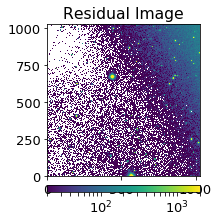

In [203]:
plt.subplots()
plt.imshow(image_data, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower', norm=LogNorm(20,2000))
plt.xlim(200, 300)
plt.ylim(200, 300)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower', norm=LogNorm(20,2000))
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)


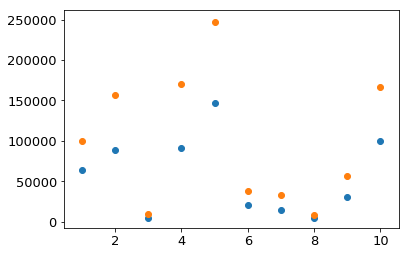

In [210]:
fig, ax = plt.subplots()
ax.scatter(total_table["id"], total_table["residual_aperture_sum"])
#ax.scatter(total_table["id"], total_table["aperture_sum_0"])
#ax.scatter(result_tab["id"], result_tab["flux_0"])
ax.scatter(result_tab["id"], result_tab["flux_fit"])
plt.show()